In [1]:
from lib import ae_tester
import sys
sys.path.insert(0, '../src')
from lib import datasets

from os.path import join as opj
import pandas as pd
import numpy as np
import torch
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Directories 
data_dir='../data/preprocessed/NeuroVault_dataset'
results_dir='../data/derived/NeuroVault_dataset'
figures_dir = '../figures'

In [3]:
# Specific setup
preprocess_type='resampled_masked_normalized'
training_subset = 'neurovault_dataset'
testing_subset = 'test_neurovault_dataset'

# Computing AutoEncoder performances

In [4]:
for model_to_use in ['4layers', '5layers']:
    training_setup = f"neurovault_dataset_maps_resampled_masked_normalized_{training_subset}_epochs_200" + \
                f"_batch_size_32_model_cnn_{model_to_use}_lr_1e-04" 
            
    if os.path.exists(opj(figures_dir, f'correlations_model_cnn_{model_to_use}.csv')):
        print('Correlation file exists for model', model_to_use)        
    else:
        print('Evaluation of performance...')
        test_dataset = datasets.ImageDataset(opj(data_dir, preprocess_type), 
                                             opj(data_dir,  testing_subset + '.txt'))

        parameter_file = opj(results_dir, training_setup, 'model_final.pt')

        model_parameter = torch.load(parameter_file, map_location="cpu")

        correlation_df = ae_tester.tester(test_dataset, model_parameter, plot=False) # Performance evaluation
        correlation_df.to_csv(opj(figures_dir, f'correlations_model_cnn_{model_to_use}.csv'))

        print('Done.')

Correlation file exists for model 4layers
Correlation file exists for model 5layers


# Figures and tables

## Table 2 - Reconstruction performance of the CAE depending on model architecture and training set. Values are the mean Pearson's correlation coefficients (standard error of the mean).

In [5]:
for model_to_use in ['4layers', '5layers']:
    print('Model:', model_to_use)
    correlation_df = pd.read_csv(opj(figures_dir, 
    f'correlations_model_cnn_{model_to_use}.csv'))

    print(round(np.mean(correlation_df['0']) * 100, 1), '(', 
          round(np.std(correlation_df['0'])/np.sqrt(len(correlation_df['0'])) * 100, 2), ')')

Model: 4layers
86.9 ( 0.18 )
Model: 5layers
77.8 ( 0.23 )


## Figure 3 - Original version and reconstruction of a randomly drawn statistic map of NeuroVault test dataset (image ID: 109) with the two CAEs (4-layers and 5-layers).

/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


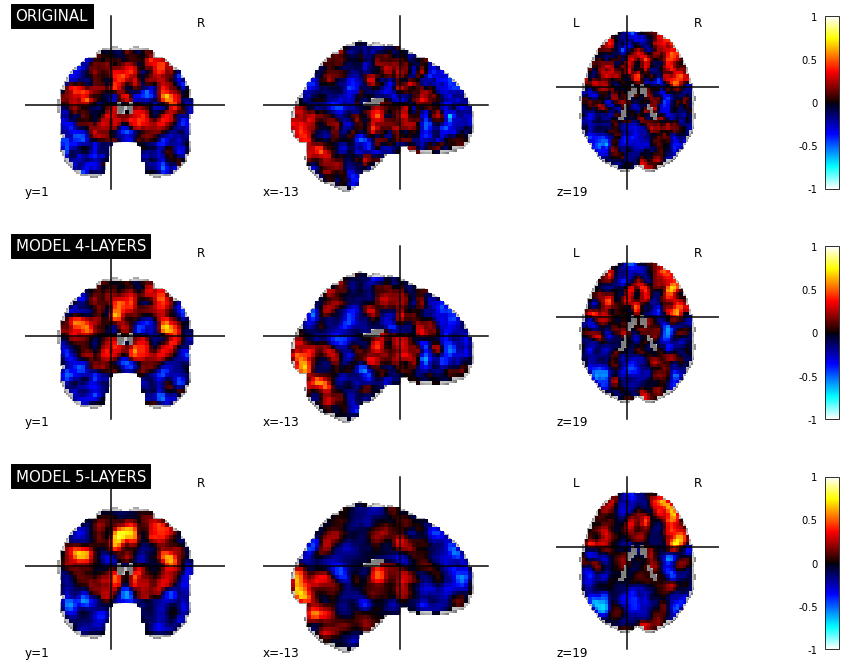

In [6]:
f = plt.figure(figsize = (15, 12))
gs = f.add_gridspec(3, 1)
ax1 = f.add_subplot(gs[0, 0])
ax2 = f.add_subplot(gs[1, 0])
ax3 = f.add_subplot(gs[2, 0])

test_dataset = datasets.ImageDataset(opj(data_dir, preprocess_type), 
                opj(data_dir,  testing_subset + '.txt'))
    
idx = 4
img = sorted(test_dataset.data)[idx]

tmp = nib.load(img)
affine = tmp.affine.copy()
header = tmp.header

# Input image (ORIGINAL)
in_tensor = ae_tester.image_to_tensor(tmp)
in_img = ae_tester.recreate_image(in_tensor, affine, header)

plotting.plot_stat_map(in_img, cut_coords = [-13, 1, 19], title = f"ORIGINAL", figure = f, axes = ax1)

for model_to_use in ['4layers', '5layers']:
    training_setup = f"neurovault_dataset_maps_resampled_masked_normalized_{training_subset}_epochs_200" + \
                f"_batch_size_32_model_cnn_{model_to_use}_lr_1e-04" 
    
    # Model

    parameter_file = opj(results_dir, training_setup, 'model_final.pt')
    model_parameter = torch.load(parameter_file, map_location="cpu")
    
    # Output image (RECONSTRUCTION)

    out_tensor = model_parameter(in_tensor)
    out_img = ae_tester.recreate_image(out_tensor, affine, header, out_img = True)
    
    correlation = ae_tester.get_correlation(in_img, out_img)
    
    if model_to_use == '4layers':
        l = '4-LAYERS'
        ax = ax2
    else:
        l='5-LAYERS'
        ax = ax3
        
    plotting.plot_stat_map(out_img, cut_coords = [-13, 1, 19], title = f"MODEL {l}", figure = f, axes = ax)
    
plt.savefig(f'../figures/fig3.png')